In [1]:
from dataset import train_set, val_set, test_set, SubsetSC

Training set size: 105829
Validation set size: 9981
Testing set size: 11005
Waveform shape: torch.Size([1, 16000])
Sample rate: 16000
Label: backward


In [2]:
import torch
import torchaudio.transforms
from typing import List, Tuple
from torch.types import Tensor
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
class Preprocessor:
    def __init__(self):
        melkwargs = {
            'n_mels': 80,
            'n_fft': 400,
            'hop_length': 160,
            'mel_scale': 'htk'
        }
        self.mfcc = torchaudio.transforms.MFCC(melkwargs=melkwargs)
        self.target_length = 16000
    def preprocess(self, waveform : Tensor) -> Tensor:
        if waveform.shape[1] != self.target_length:
            waveform = self._pad_trim(waveform)
        return self.mfcc(waveform)
    def _pad_trim(self, wav : Tensor) -> Tensor:
        size = wav.shape[1]
        if size < self.target_length:
            return torch.nn.functional.pad(wav, (0, self.target_length - size))
        else:
            return wav[:, :self.target_length]

In [4]:
classes = []
with open('classes.txt', 'r') as f:
    classes = f.read().splitlines()
label_to_class = {}
class_to_label = {}
for idx, cl in enumerate(classes):
    label_to_class[cl] = idx
    class_to_label[idx] = cl

In [5]:
def create_loader(dataset : SubsetSC, batch_size : int) -> torch.utils.data.DataLoader:
    preprocessor = Preprocessor()
    def _collate(batch):
        waveforms = []
        labels = []
        for waveform, sample_rate, label, *_ in batch:
            mfcc = preprocessor.preprocess(waveform)
            waveforms.append(mfcc)
            labels.append(torch.tensor(label_to_class[label]))
            
        # Pad sequences to same length
        waveforms = torch.nn.utils.rnn.pad_sequence(
            waveforms, 
            batch_first=True
        )
        labels = torch.stack(labels)
        return waveforms, labels
    return torch.utils.data.DataLoader(dataset=dataset,
                    batch_size=batch_size,
                    shuffle=True,
                    collate_fn=_collate)

In [6]:
class SpeechCNN(nn.Module):
    def __init__(self, num_classes=35, dropout_rate=0.5):
        super().__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        self.adaptive_pool = nn.AdaptiveAvgPool2d((4, 4))
        
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        if len(x.shape) == 3:
            x = x.unsqueeze(1)
            
        # Conv blocks
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        
        # Adaptive pooling
        x = self.adaptive_pool(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

In [7]:
class History:
    def __init__(self):
        self.history = {
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'lr': []
        }
        self.best_val_loss = float('inf')
        self.best_val_acc = 0
        self.best_epoch = 0
        
    def update(self, epoch : int, train_loss : float, train_acc : float,
                     val_loss : float, val_acc : float, lr : float) -> bool:
        self.history['train_loss'].append(train_loss)
        self.history['train_acc'].append(train_acc)
        self.history['val_loss'].append(val_loss)
        self.history['val_acc'].append(val_acc)
        self.history['lr'].append(lr)
        
        if val_loss < self.best_val_loss:
            self.best_val_loss = val_loss
            self.best_val_acc = val_acc
            self.best_epoch = epoch
            return True
        return False
    
    def print_epoch(self, epoch : int, epochs : int) -> None:
        print(f"\nEpoch: {epoch+1}/{epochs}")
        print(f"Train Loss: {self.history['train_loss'][-1]:.4f} | "
              f"Train Acc: {self.history['train_acc'][-1]:.2f}%")
        print(f"Validation Loss: {self.history['val_loss'][-1]:.4f} | "
              f"Validation Acc: {self.history['val_acc'][-1]:.2f}%")
        print(f"Learning Rate: {self.history['lr'][-1]:.6f}")
    def plot_metrics(self):
        import matplotlib.pyplot as plt
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Plot losses
        ax1.plot(self.history['train_loss'], label='Train Loss')
        ax1.plot(self.history['val_loss'], label='Val Loss')
        ax1.set_title('Loss History')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        
        # Plot accuracies
        ax2.plot(self.history['train_acc'], label='Train Acc')
        ax2.plot(self.history['val_acc'], label='Val Acc')
        ax2.set_title('Accuracy History')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy (%)')
        ax2.legend()
        
        plt.tight_layout()
        plt.savefig('metrics.png')
        plt.show()


In [8]:
class CNNModel:
    def __init__(self):
        self.model = SpeechCNN()
        self.best_model = SpeechCNN()
        self.best_model.load_state_dict(torch.load(f='best_model.pth'))
        self.best_model.eval()
        self.history = History()
        self.early_stopping_patience = 5  
        self.early_stopping_min_delta = 0.001  
    def predict(self, test_loader : torch.utils.data.DataLoader, model : SpeechCNN = None, device : str = 'cpu') -> List[int]:
        model = model or self.best_model
        preds = []
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                _, predicted = outputs.max(1)
                preds.append(predicted)
        return torch.cat(preds)
    def predict_single(self, wav : Tensor, model : SpeechCNN = None) -> int:
        model = model or self.best_model
        with torch.no_grad():
            # wav = self.preprocess(wav)
            outputs = model(wav)
            _, predicted = outputs.max(1)
        return predicted

    def fit(self, train_loader : torch.utils.data.DataLoader,
            val_loader : torch.utils.data.DataLoader,
            epochs : int = 30,
            device : str = 'cpu'):
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=0.005, weight_decay=0.01)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, 
            mode='min', 
            factor=0.5, 
            patience=3,
            min_lr=0.0001
        )
        
        self.model = self.model.to(device)
        # Add early stopping variables
        no_improve_count = 0
        min_val_loss = float('inf')
        
        for epoch in range(epochs):
            # Training phase
            self.model.train()
            train_loss = 0
            train_correct = 0
            train_total = 0
            
            for batch_idx, (inputs, targets) in enumerate(tqdm(train_loader)):
                inputs, targets = inputs.to(device), targets.to(device)
                
                optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item()
                _, predicted = outputs.max(1)
                train_total += targets.size(0)
                train_correct += predicted.eq(targets).sum().item()
            
            # Validation phase
            self.model.eval()
            val_loss = 0
            val_correct = 0
            val_total = 0
            
            with torch.no_grad():
                for inputs, targets in val_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    outputs = self.model(inputs)
                    loss = criterion(outputs, targets)
                   
                    val_loss += loss.item()
                    _, predicted = outputs.max(1)
                    val_total += targets.size(0)
                    val_correct += predicted.eq(targets).sum().item()
            
            # Calculate metrics
            train_loss = train_loss / len(train_loader)
            train_acc = 100. * train_correct / train_total
            val_loss = val_loss / len(val_loader)
            val_acc = 100. * val_correct / val_total
            scheduler.step(val_loss)

            # Early stopping check
            if val_loss < (min_val_loss - self.early_stopping_min_delta):
                min_val_loss = val_loss
                no_improve_count = 0
            else:
                no_improve_count += 1
            
            if no_improve_count >= self.early_stopping_patience:
                print(f'\nEarly stopping triggered after epoch {epoch + 1}')
                break

            best = self.history.update(epoch, train_loss, train_acc, val_loss, val_acc, optimizer.param_groups[0]['lr'])
            self.history.print_epoch(epoch, epochs)
            
            torch.save(self.model.state_dict(), f'./models/model_{epoch}_{val_acc:.2f}_.pth')
            if best:
                torch.save(self.model.state_dict(), 'best_model.pth')
                self.best_model = self.model

In [9]:
# mini_train = [train_set[i] for i in range(0, 100)]
# mini_val = [val_set[i] for i in range(0, 100)]
train_loader = create_loader(train_set, 32)
val_loader = create_loader(val_set, 32)

model = CNNModel()
model.fit(train_loader, val_loader, epochs=30)
model.history.plot_metrics()



/tmp/ipykernel_304625/3724598538.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.best_model.load_state_dict(torch.load(f='best_model.pth'))
100%|██████████| 3308/33


Epoch: 1/30
Train Loss: 2.3948 | Train Acc: 31.12%
Validation Loss: 0.8687 | Validation Acc: 73.06%
Learning Rate: 0.005000


100%|██████████| 3308/3308 [14:36<00:00,  3.77it/s]



Epoch: 2/30
Train Loss: 0.9603 | Train Acc: 71.23%
Validation Loss: 0.4470 | Validation Acc: 86.82%
Learning Rate: 0.005000


100%|██████████| 3308/3308 [14:23<00:00,  3.83it/s]



Epoch: 3/30
Train Loss: 0.6365 | Train Acc: 81.48%
Validation Loss: 0.3560 | Validation Acc: 88.95%
Learning Rate: 0.005000


100%|██████████| 3308/3308 [14:31<00:00,  3.80it/s]



Epoch: 4/30
Train Loss: 0.5135 | Train Acc: 85.15%
Validation Loss: 0.3031 | Validation Acc: 90.61%
Learning Rate: 0.005000


100%|██████████| 3308/3308 [14:28<00:00,  3.81it/s]



Epoch: 5/30
Train Loss: 0.4432 | Train Acc: 87.21%
Validation Loss: 0.2369 | Validation Acc: 93.07%
Learning Rate: 0.005000


100%|██████████| 3308/3308 [14:41<00:00,  3.75it/s]



Epoch: 6/30
Train Loss: 0.4108 | Train Acc: 88.13%
Validation Loss: 0.2577 | Validation Acc: 92.47%
Learning Rate: 0.005000


100%|██████████| 3308/3308 [14:36<00:00,  3.77it/s]



Epoch: 7/30
Train Loss: 0.3868 | Train Acc: 88.89%
Validation Loss: 0.2404 | Validation Acc: 92.80%
Learning Rate: 0.005000


100%|██████████| 3308/3308 [14:42<00:00,  3.75it/s]



Epoch: 8/30
Train Loss: 0.3661 | Train Acc: 89.47%
Validation Loss: 0.2462 | Validation Acc: 92.65%
Learning Rate: 0.005000


100%|██████████| 3308/3308 [14:35<00:00,  3.78it/s]



Epoch: 9/30
Train Loss: 0.3530 | Train Acc: 89.75%
Validation Loss: 0.2072 | Validation Acc: 93.86%
Learning Rate: 0.005000


100%|██████████| 3308/3308 [14:05<00:00,  3.91it/s]



Epoch: 10/30
Train Loss: 0.3453 | Train Acc: 89.93%
Validation Loss: 0.2264 | Validation Acc: 93.07%
Learning Rate: 0.005000


100%|██████████| 3308/3308 [14:44<00:00,  3.74it/s]



Epoch: 11/30
Train Loss: 0.3427 | Train Acc: 90.22%
Validation Loss: 0.2135 | Validation Acc: 93.67%
Learning Rate: 0.005000


100%|██████████| 3308/3308 [14:35<00:00,  3.78it/s]



Epoch: 12/30
Train Loss: 0.3297 | Train Acc: 90.49%
Validation Loss: 0.2363 | Validation Acc: 92.54%
Learning Rate: 0.005000


100%|██████████| 3308/3308 [14:45<00:00,  3.74it/s]



Epoch: 13/30
Train Loss: 0.3210 | Train Acc: 90.75%
Validation Loss: 0.1839 | Validation Acc: 94.54%
Learning Rate: 0.005000


100%|██████████| 3308/3308 [14:42<00:00,  3.75it/s]



Epoch: 14/30
Train Loss: 0.3194 | Train Acc: 90.76%
Validation Loss: 0.1769 | Validation Acc: 94.59%
Learning Rate: 0.005000


100%|██████████| 3308/3308 [14:35<00:00,  3.78it/s]



Epoch: 15/30
Train Loss: 0.3158 | Train Acc: 90.93%
Validation Loss: 0.2010 | Validation Acc: 93.92%
Learning Rate: 0.005000


100%|██████████| 3308/3308 [15:01<00:00,  3.67it/s]



Epoch: 16/30
Train Loss: 0.3095 | Train Acc: 91.06%
Validation Loss: 0.2131 | Validation Acc: 93.82%
Learning Rate: 0.005000


 36%|███▌      | 1193/3308 [05:36<09:56,  3.54it/s]


KeyboardInterrupt: 

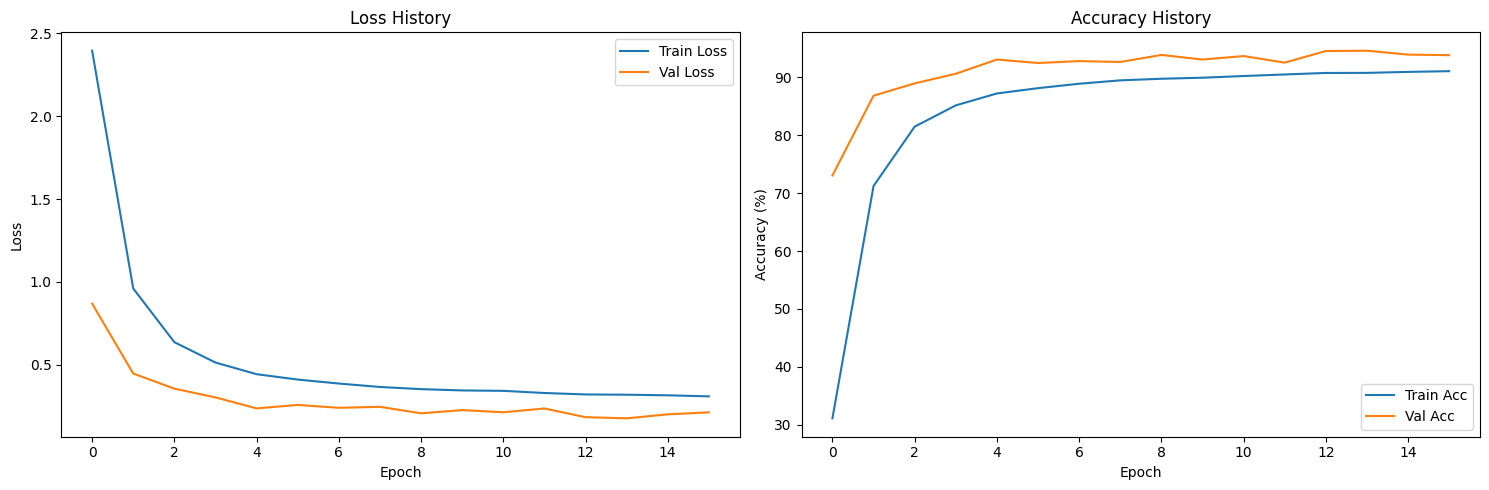

In [10]:
model.history.plot_metrics()

In [12]:
mini_test = [test_set[i] for i in range(500, 550)]
test_loader = create_loader(mini_test, 32)
preds = model.predict(test_loader)
preds = [class_to_label[pred.item()] for pred in preds]
for pred, label in zip(preds, mini_test):
    print(pred != label[2])

True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False


In [34]:
prep = Preprocessor()
wav, _, _, *_ = mini_test[0]
wav = prep.preprocess(wav)
model.predict_single(wav)

tensor([2])